In [ ]:
%reset

In [51]:
%run './Functions.ipynb'

# 0. Functions

In [52]:
#Transforming weights into a heatmap-like df

def make_tables(chunk, n):
    index = set([x[-1] for x in unique_mutations[chunk]])
    columns = set([int(x[:-1]) for x in unique_mutations[chunk]])
    df_0 = pd.DataFrame(index=sorted(index), columns=columns).astype(float) # dummy dfs for each of the entrance neurons
    df_1 = pd.DataFrame(index=sorted(index), columns=columns).astype(float)
    
    for i in range(len(train_weights[chunk][n])):
        position = unique_mutations[chunk][i][:-1]
        mutation = unique_mutations[chunk][i][-1]
        df_0[int(position)][mutation] = (train_weights[chunk][n][i][0]).astype(float)
        df_1[int(position)][mutation] = (train_weights[chunk][n][i][1]).astype(float)
        
    return df_0,df_1

In [53]:
def extract_differences(chunk, n):
    mask = {}
    df = {}
    
    mask[0],mask[1] = make_tables(chunk,n)
    for key in mask:
        mask[key][mask[key]>0]=1
        mask[key][mask[key]<0]=-1
    
    mask = (mask[0] - mask[1]).fillna(0)
    df[0],df[1] = make_tables(chunk,n)
    
    return (df[0][mask!=0]-df[1][mask!=0]).fillna(0)

In [54]:
def count_occurences(chunk,n):
    effects = {}
    for n in range(n):
        result = extract_differences(chunk, n)
        for i in result.index:
            for j in result.columns:
                if result[j].ix[i]!=0:
                    if str(j)+str(i) not in effects.keys():
                        effects[str(j)+str(i)] = []
                        effects[str(j)+str(i)].append(result[j].ix[i])
                    else:
                        effects[str(j)+str(i)].append(result[j].ix[i])
    return effects

# 1. Training models and extracting weights

### 1.1. Test conditions on one sample

In [58]:
chunk = 'S7'

data, labels, unique_mutations, aa_seq = read_data(chunk)

train_weights[chunk]={}
cv = cross_validation.StratifiedKFold(labels, n_folds = 10, shuffle = True)
counter = 0

for train_idx, test_idx in cv:
    print (counter)
    X_train, y_train = data[train_idx,:], labels[train_idx]
    X_test, y_test = data[test_idx,:], labels[test_idx]

    model = Sequential()
    init = initializers.Orthogonal(gain=1.0, seed=None)

    model.add(Dense(2, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
    model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)

    model.fit(X_train, y_train, epochs=500, batch_size=500, shuffle=True, verbose=0)
    
    train_weights[chunk][counter] = model.layers[0].get_weights()[0]
    
    counter += 1

0
1
2
3
4
5
6
7
8
9


In [62]:
for chunk in ['S7']:
    print chunk
    for i in range(10):
        _,_,R,_,_ = stats.linregress(train_weights[chunk][i][:,0],train_weights[chunk][i][:,1])

        print chunk,i,R

S7
S7 0 -0.52707486126
S7 1 0.745335421697
S7 2 0.0260111429463
S7 3 -0.0577933744545
S7 4 0.714662737453
S7 5 0.0238933313466
S7 6 0.734423990393
S7 7 0.759626661852
S7 8 0.0920336746777
S7 9 0.656434053168


In [37]:
toprint = {}
for chunk in ['S5']:
    print chunk
    d = count_occurences(chunk,20)
    for key in d:
        if len(d[key])>10:
            print key+'\t'+str(np.median([np.abs(x) for x in d[key]]))+'\t'+str(np.std([np.abs(x) for x in d[key]]))+'\t'+str(len(d[key]))
    print '\n'

S5
2T	0.543092928827	0.165919797132	11
25L	1.61543478072	0.448285557388	14
21A	2.54797014594	1.98931401822	14
25S	0.929264426231	0.253345615892	12
22S	2.54611752182	0.68615643076	11




### 1.2. Performing the operation on all the samples

In [67]:
unique_mutations = {}

for chunk in chunks:
    print chunk
    data, labels, unique_mutations[chunk], aa_seq = read_data(chunk)

S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12


In [72]:
train_weights = {}
true = {}
predicted = {}
fitness_potential = {}


for chunk in chunks:
    print chunk
    data, labels, unique_mutations, aa_seq = read_data(chunk)
    
    train_weights[chunk]={}
    true[chunk] = {}
    predicted[chunk] = {}
    fitness_potential[chunk] = {}
    
    cv = cross_validation.StratifiedKFold(labels, n_folds = 10, shuffle = True)
    counter = 0

    for train_idx, test_idx in cv:
        print (counter)
        X_train, y_train = data[train_idx,:], labels[train_idx]
        X_test, y_test = data[test_idx,:], labels[test_idx]

        model = Sequential()
        init = initializers.Orthogonal(gain=1.0, seed=None)

        model.add(Dense(2, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
        model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
        model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

        opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

        model.compile(optimizer=opt,
                      loss='mean_squared_error',
                      verbose=0)

        model.fit(X_train, y_train, epochs=500, batch_size=500, shuffle=True, verbose=0)
        
        proba = model.predict_proba(X_train, batch_size=500, verbose=0)
        true[chunk][counter] = y_train
        predicted[chunk][counter] = proba.flatten()
        
        train_weights[chunk][counter] = model.layers[0].get_weights()[0]
        fitness_potential[chunk][counter] = X_train.dot(train_weights[chunk][counter])

        counter += 1

S1
0
1
2
3
4
5
6
7
8
9
S2
0
1
2
3
4
5
6
7
8
9
S3
0
1
2
3
4
5
6
7
8
9
S4
0
1
2
3
4
5
6
7
8
9
S5
0
1
2
3
4
5
6
7
8
9
S6
0
1
2
3
4
5
6
7
8
9
S7
0
1
2
3
4
5
6
7
8
9
S8
0
1
2
3
4
5
6
7
8
9
S9
0
1
2
3
4
5
6
7
8
9
S10
0
1
2
3
4
5
6
7
8
9
S11
0
1
2
3
4
5
6
7
8
9
S12
0
1
2
3
4
5
6
7
8
9


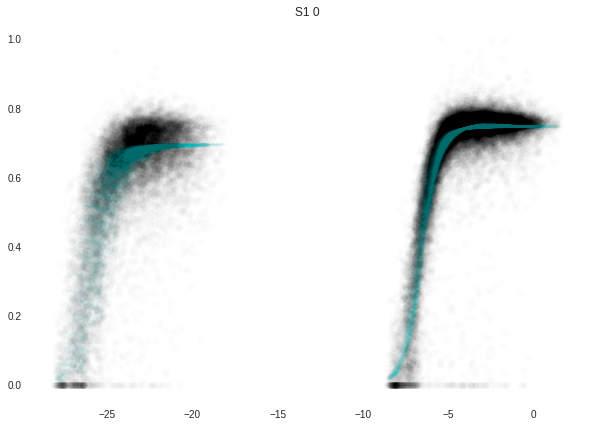

In [135]:
chunk = 'S1'
i=0

plt.figure(figsize = [10,7])
plt.plot(fitness_potential[chunk][i][:,1], true[chunk][i], 'ok', alpha = 0.01)
# plt.plot(fitness_potential[chunk][i][:,0], predicted[chunk][i], '.m', alpha = 0.01)
plt.plot(fitness_potential[chunk][i][:,1], predicted[chunk][i], '.c', alpha = 0.01)
plt.title(chunk+' '+str(i));

S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12


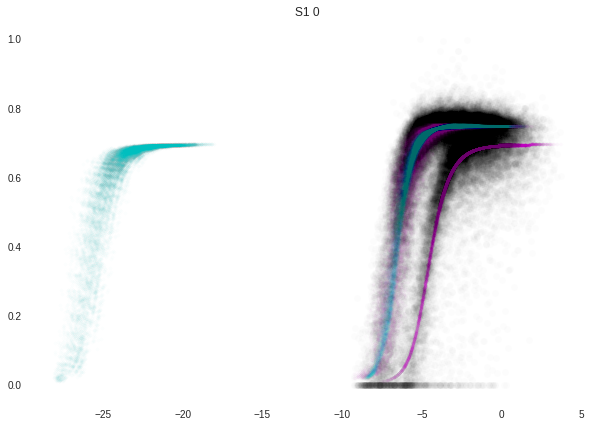

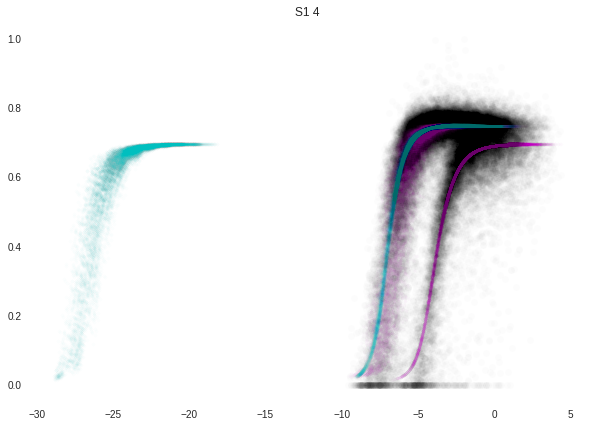

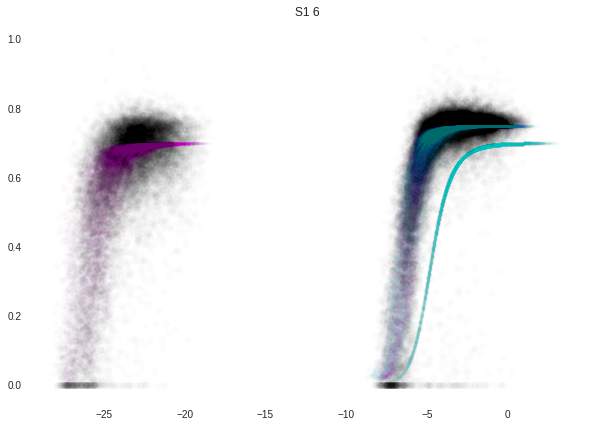

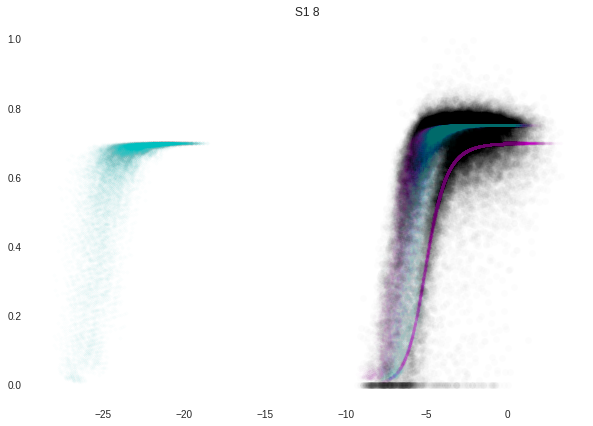

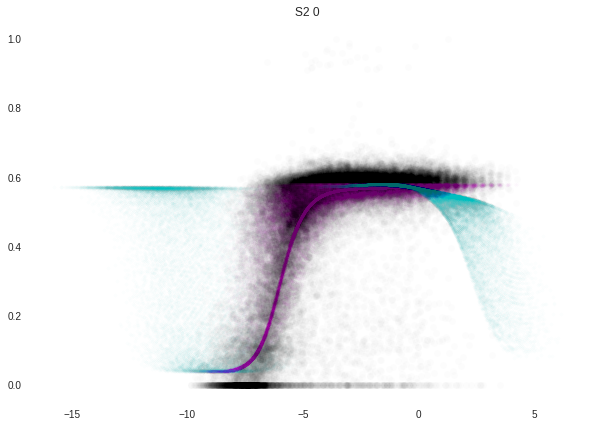

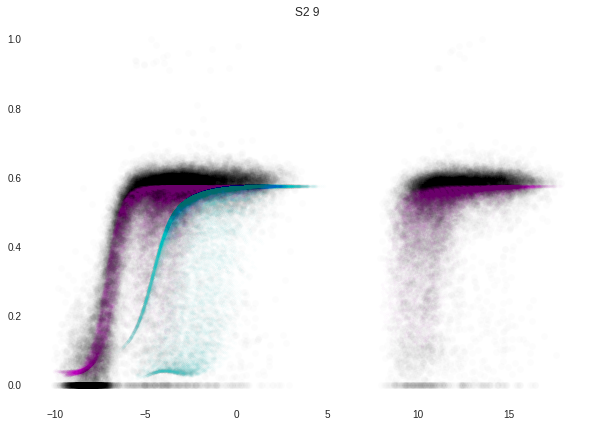

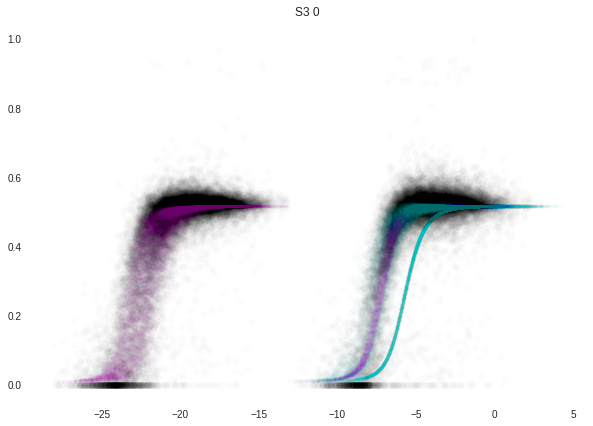

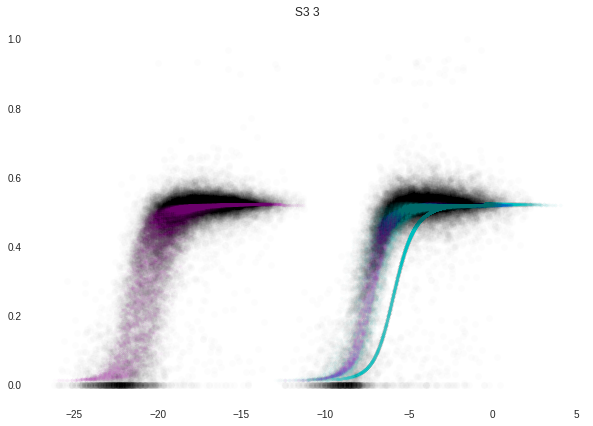

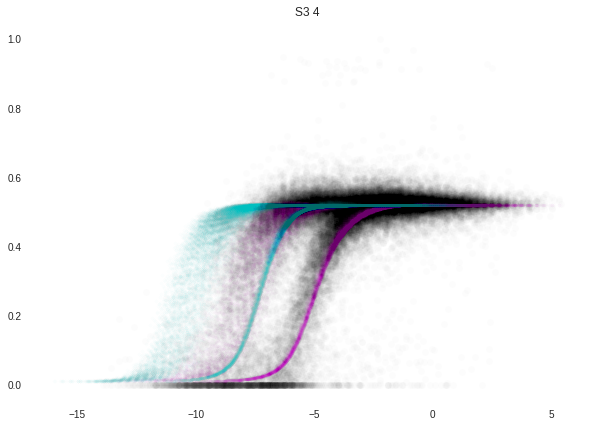

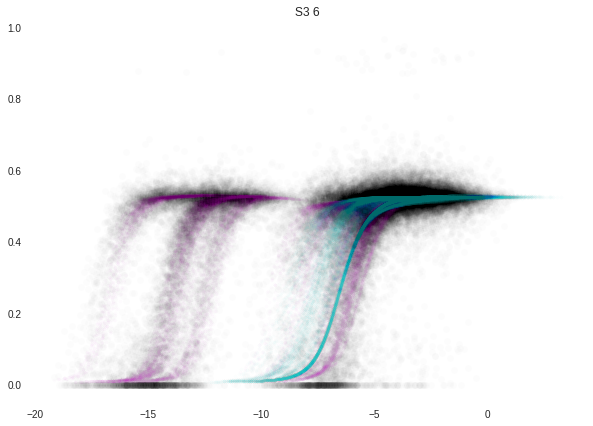

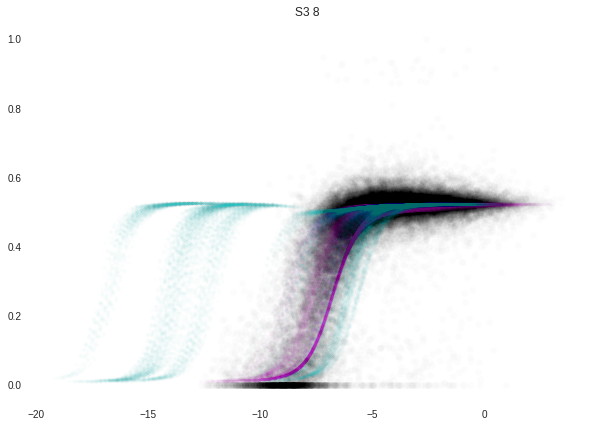

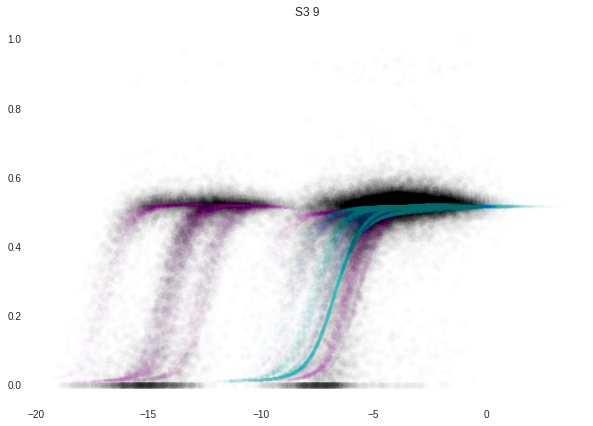

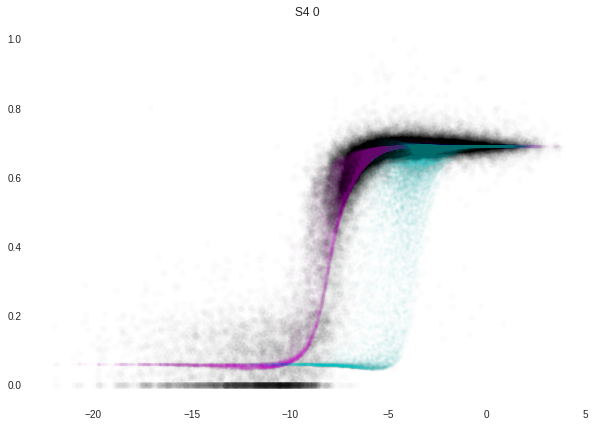

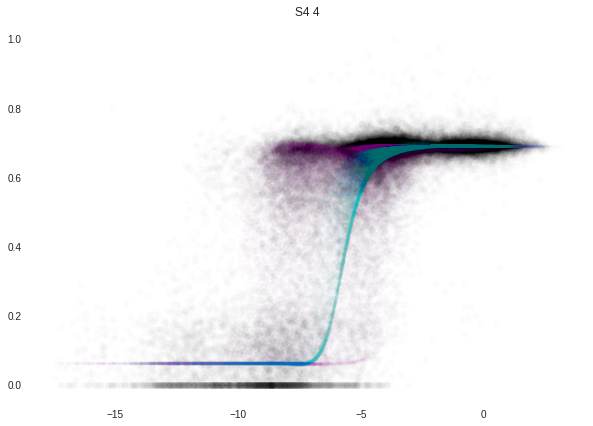

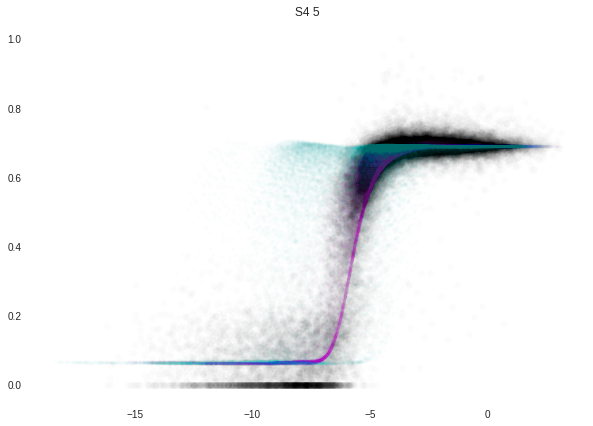

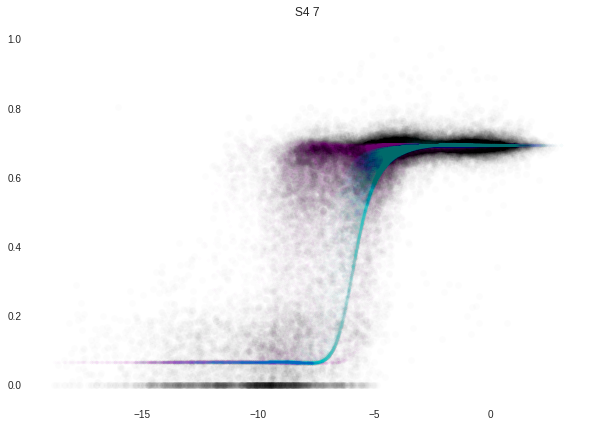

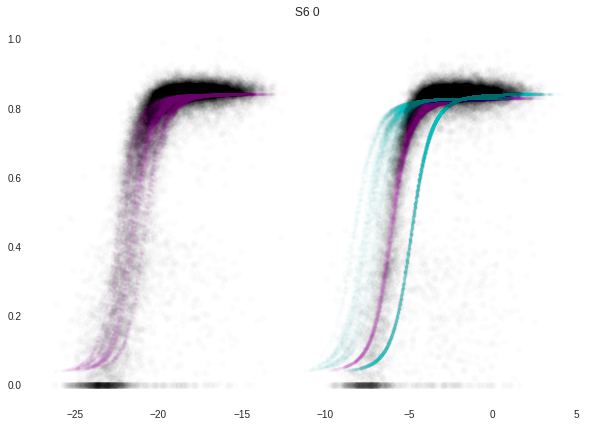

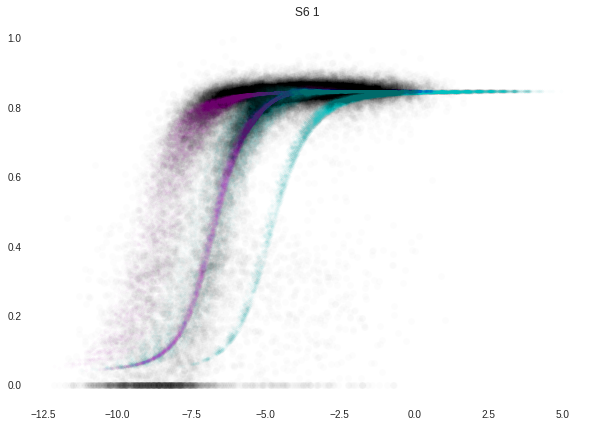

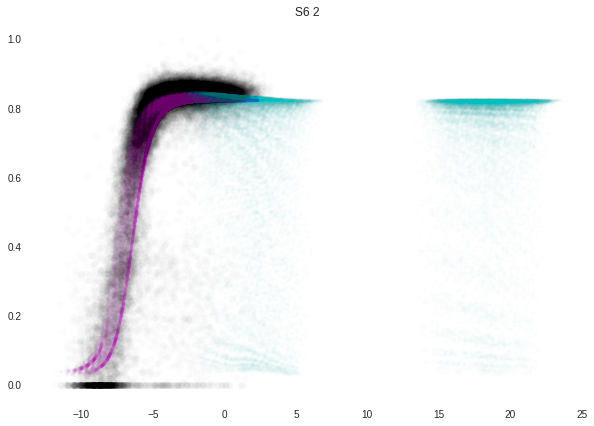

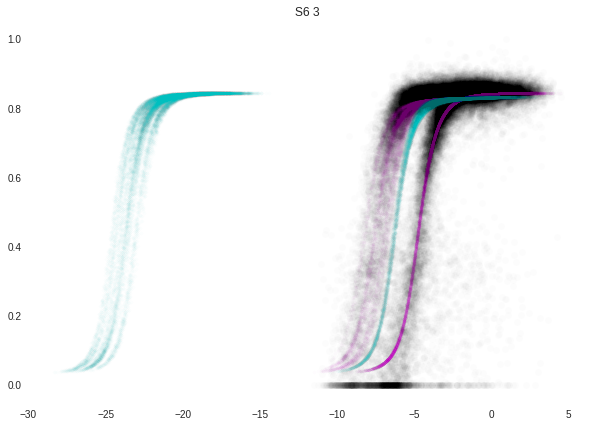

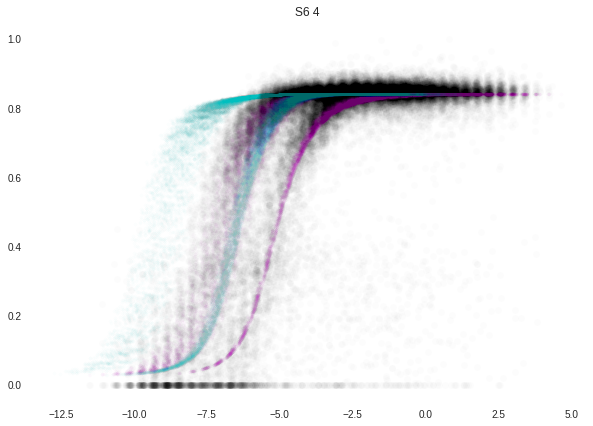

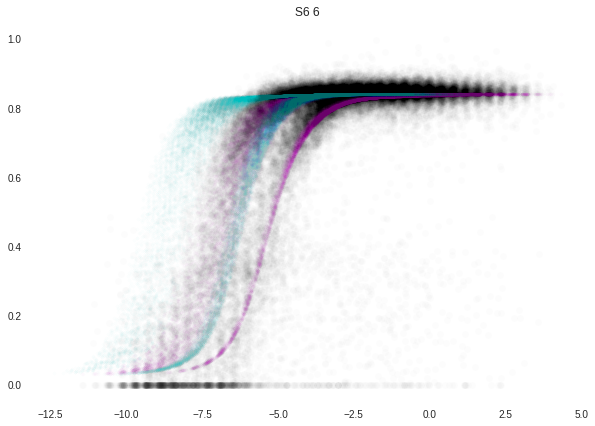

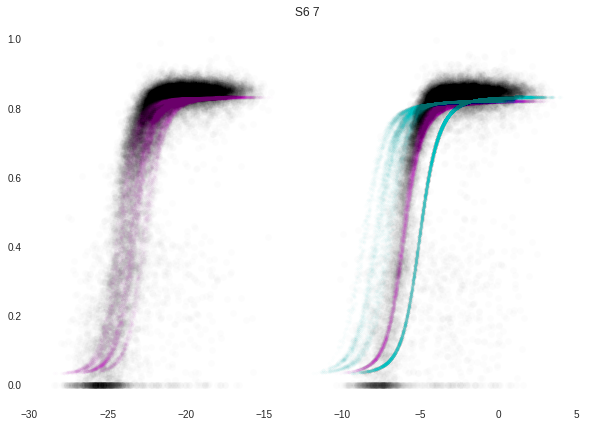

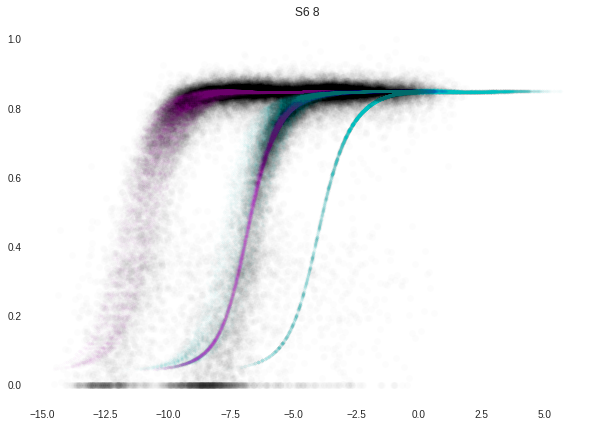

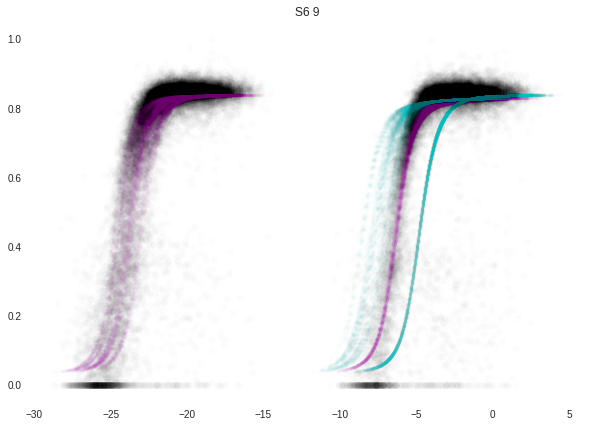

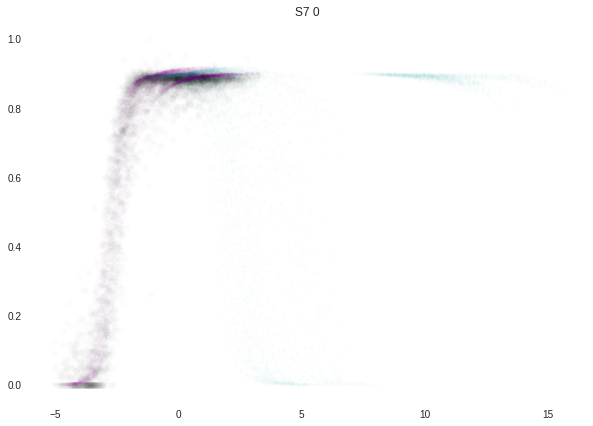

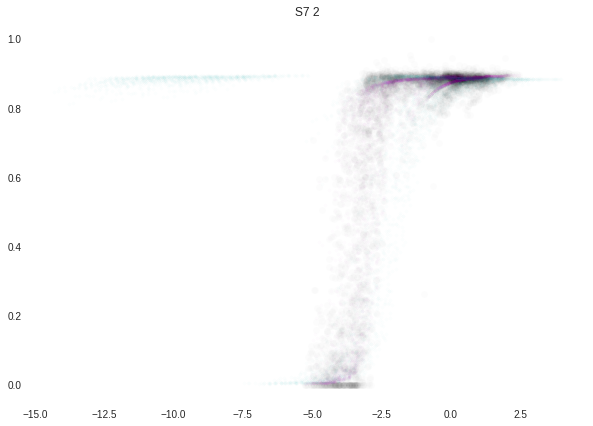

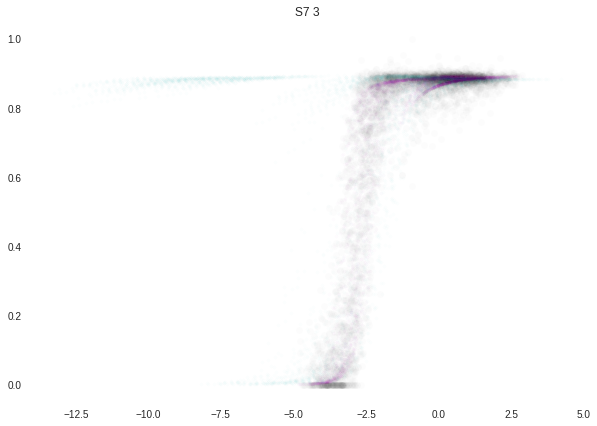

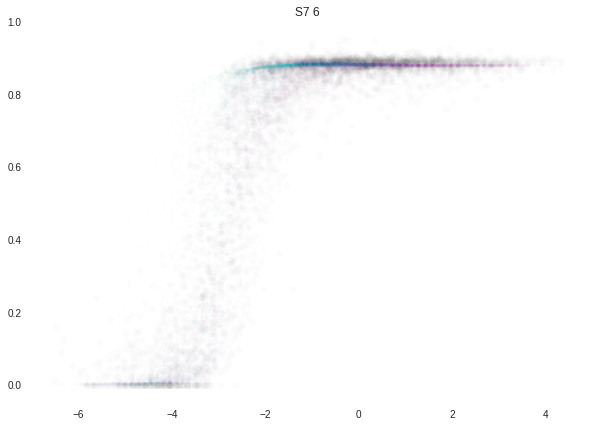

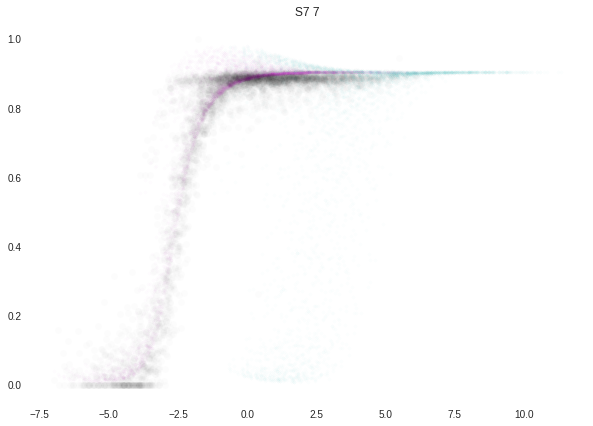

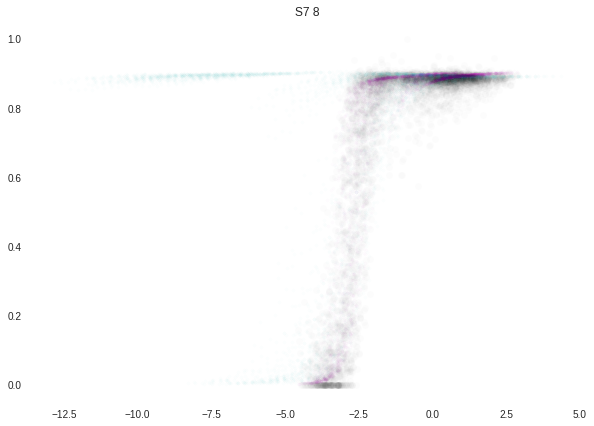

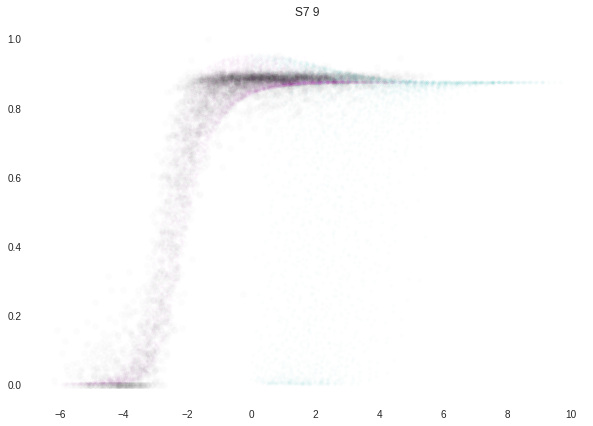

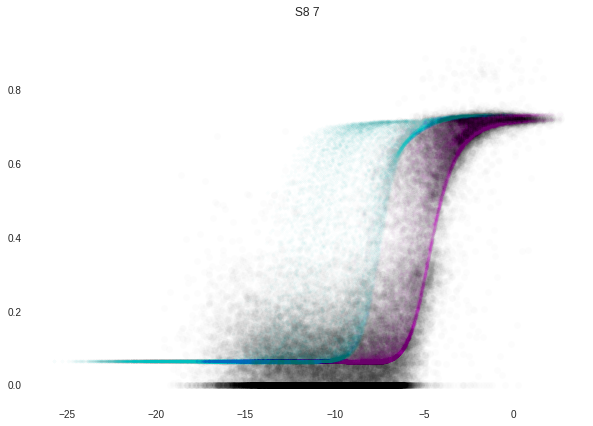

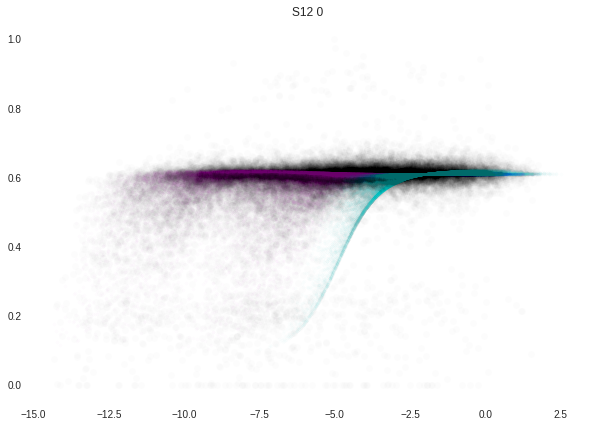

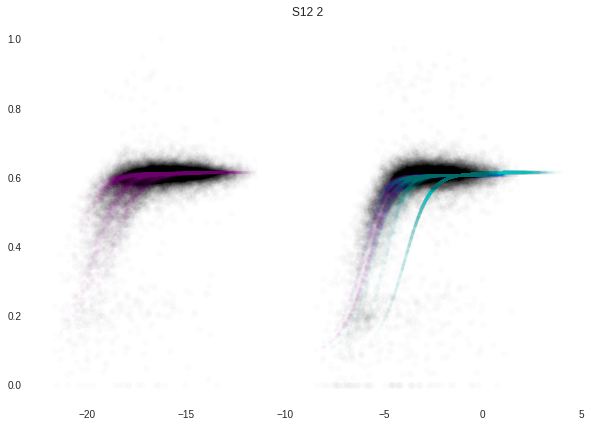

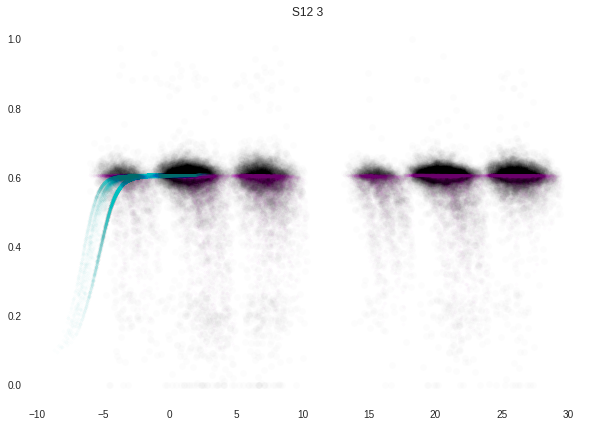

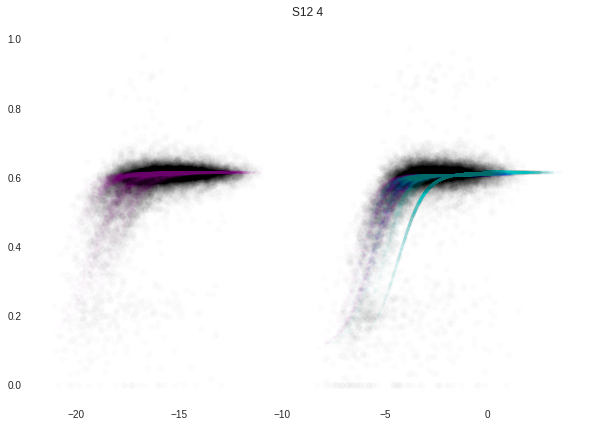

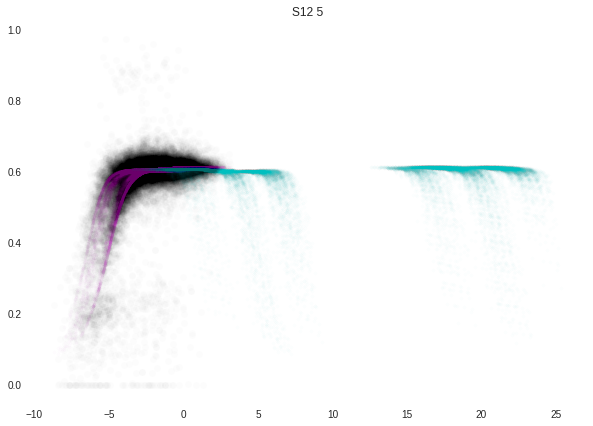

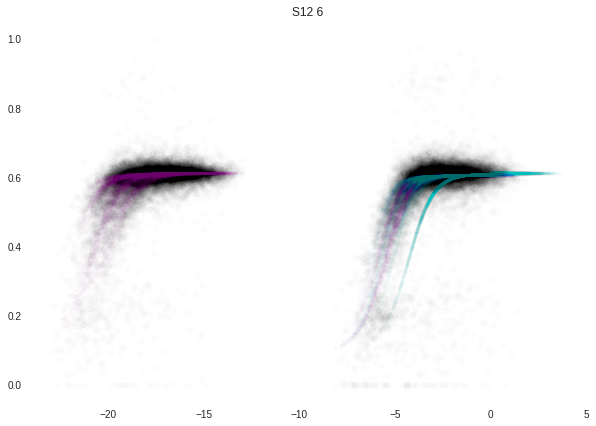

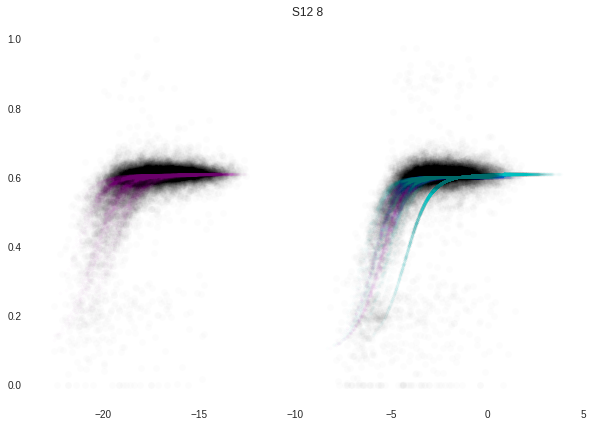

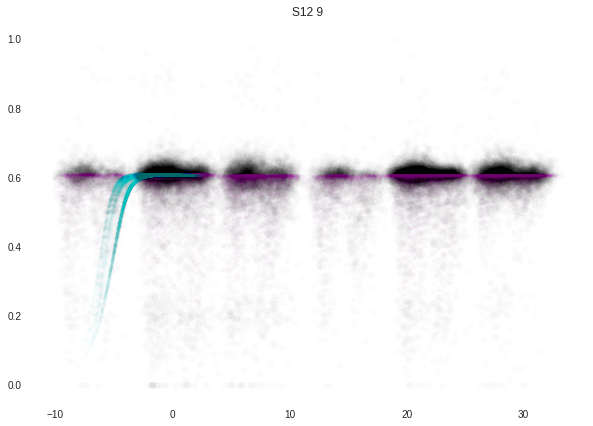

In [113]:
for chunk in chunks:
    print chunk
    for i in range(10):

        _,_,R1,_,_ = stats.linregress(predicted[chunk][i],fitness_potential[chunk][i][:,0])
        _,_,R2,_,_ = stats.linregress(predicted[chunk][i],fitness_potential[chunk][i][:,1])
        _,_,Rfit,_,_ = stats.linregress(true[chunk][i],predicted[chunk][i])

        if Rfit>0.7 and R1>0 and R2>0:

            plt.figure(figsize = [10,7])
            plt.plot(fitness_potential[chunk][i][:,0], true[chunk][i], 'ok', alpha = 0.01)
            plt.plot(fitness_potential[chunk][i][:,0], predicted[chunk][i], '.m', alpha = 0.01)
            plt.plot(fitness_potential[chunk][i][:,1], predicted[chunk][i], '.c', alpha = 0.01)
            plt.title(chunk+' '+str(i));

In [106]:
for chunk in chunks:
    print chunk
    for i in range(10):
        _,_,R,_,_ = stats.linregress(train_weights[chunk][i][:,0],train_weights[chunk][i][:,1])
        print (R)

S1
-0.109760590451
0.235621073957
0.213012100694
0.225093209172
-0.207160173861
0.244019710467
-0.102016423898
0.213743273523
-0.093873305771
0.221526813968
S2
-0.0639771875089
-0.522317996846
0.351678302115
0.332845332806
-0.415471943585
0.296305606053
-0.159205112492
-0.63678462114
0.346665531346
0.270495895288
S3
-0.161655870393
0.421144924969
-0.525100826004
-0.100377973717
0.399667936899
0.515523330675
0.192943178316
0.436213268675
0.193153635369
0.20302421561
S4
0.877269117931
-0.864946323547
0.505421329581
-0.54749025924
0.817271748727
0.825848777128
-0.855852168253
0.868670675028
-0.821135754077
0.546414680217
S5
0.271999820811
0.281900852487
0.274370456003
0.264492011309
0.635410190594
0.199111735083
0.226124557854
-0.409322687732
-0.431129854219
-0.436340689972
S6
-0.219542410592
0.718903537609
0.468515892924
-0.271892637981
0.625319889241
0.348335203827
0.655720293759
-0.232782666671
0.18353213423
-0.272575027559
S7
0.0922395979696
0.791322278469
-0.0242111547386
0.041199088

In [68]:
toprint = {}
for chunk in chunks:
    print chunk
    d = count_occurences(chunk,10)
    for key in d:
        if len(d[key])>5:
            print key+'\t'+str(np.median([np.abs(x) for x in d[key]]))+'\t'+str(np.std([np.abs(x) for x in d[key]]))+'\t'+str(len(d[key]))
    print '\n'

S1
5F	21.4236992598	7.43412836781	9
6K	0.352036774158	0.258984342759	9
6T	0.110778974835	0.229354571169	8


S2
21T	0.159159854054	0.016865254961	6
5S	0.870091430843	0.0894031426868	7
24V	0.199487285689	0.0273024344848	6
7T	4.3865866065	1.79640461034	6
7I	12.9433249533	5.42198886172	7
5C	1.33665192127	0.201217002958	6
25T	0.722026303411	0.0675201029587	6


S3
20Q	0.168575979769	0.646696373405	6
7I	0.323234691285	0.0232428766912	6
2F	14.7938319445	7.55680497036	7


S4
29M	1.50270792842	0.26638824191	8
1G	1.15942680836	0.262313023227	7
4M	0.594251424074	0.158882725571	7


S5
2T	0.675078645349	0.192190868085	8
0Y	1.88040480018	0.405669127766	6
25L	1.69593337178	0.833248420766	6
21A	2.60399207473	0.547757952768	6
25S	1.00926123559	0.427368450458	6
0H	3.6432890892	0.630468991902	6
22S	2.96943438053	0.61159731149	9


S6


S7
27L	0.807517506182	0.547195066584	7
0F	2.22128485888	0.453768601709	6
20D	0.500680483878	0.300435028375	6


S8
22L	1.80531343818	0.261450362522	7
26G	1.86354634166	0.3037

In [71]:
for chunk in chunks:
    print chunk
    for i in range(10):
        _,_,R,_,_ = stats.linregress(train_weights[chunk][i][:,0],train_weights[chunk][i][:,1])
        print chunk,i,R
        
    print '\n'

S1
S1 0 -0.0943362827874
S1 1 0.227777249759
S1 2 -0.211019481694
S1 3 -0.252418737901
S1 4 -0.167492516471
S1 5 -0.199389270268
S1 6 -0.117672658735
S1 7 -0.144627036415
S1 8 -0.237118493067
S1 9 -0.0766882032542


S2
S2 0 0.359509896722
S2 1 0.147376147943
S2 2 -0.365739203141
S2 3 0.206093513227
S2 4 0.380646423039
S2 5 0.275384460768
S2 6 0.351824810743
S2 7 -0.688376936957
S2 8 -0.703825080334
S2 9 -0.393916215807


S3
S3 0 0.466119060054
S3 1 0.422901147297
S3 2 0.416219134303
S3 3 -0.149796439929
S3 4 -0.300140372059
S3 5 -0.15854001651
S3 6 0.515384204377
S3 7 -0.152516706302
S3 8 0.265316571131
S3 9 -0.146624713629


S4
S4 0 0.831208149375
S4 1 -0.870326401009
S4 2 0.0474837586931
S4 3 -0.776876034321
S4 4 0.783308275296
S4 5 0.852979562724
S4 6 0.47705873794
S4 7 0.833939811876
S4 8 0.843704855639
S4 9 0.880601375954


S5
S5 0 -0.399518431598
S5 1 0.252367819804
S5 2 0.273442685289
S5 3 -0.303564445795
S5 4 -0.370311408437
S5 5 -0.157748897128
S5 6 -0.342106290242
S5 7 0.2744